Using covariance from a suite of tracers to design the diffusion matrix.

In [11]:
import stompy.model.delft.dflow_model as dfm
from stompy.grid import unstructured_grid
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import colors
import pandas as pd
import statsmodels.formula.api as smf
from IPython import display

from stompy.spatial import proj_utils
from stompy.spatial import interp_4d
import six

from stompy import utils

%matplotlib notebook

In [12]:
from stompy.model import data_comparison
import extrap_common
six.moves.reload_module(extrap_common)

<module 'extrap_common' from '/home/rustyh/src/sfb_csc_dfm/model/extrap_common.py'>

In [3]:
#model=dfm.DFlowModel.load("data_2d_2019_hybrid-v033")
#model=dfm.DFlowModel.load("data_2d_2018_hybrid-v003")
#model=dfm.DFlowModel.load("data_2d_2018_hybrid-v008")
# includes chl, and all names have been shortened in the inputs and model.
model=dfm.DFlowModel.load("data_2d_2018_hybrid-v009")

In [4]:
fig_dir=os.path.join(model.run_dir,'figures')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    

In [5]:
map_ds=model.map_dataset()

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:872: RuntimeWarning: invalid value encountered in cast
  ug.edges['cells'] = nc[mesh.attrs['edge_face_connectivity']].values


In [6]:
g=map_ds.grid

In [7]:
cov_tracers=[
    'mesh2d_tauDecay0',
    'mesh2d_tauDecay1',
    'mesh2d_turb_wt',
    'mesh2d_turb_wtobs',
    'mesh2d_sa1',
]

In [8]:
from stompy import memoize

spinup_period = np.timedelta64(10,'D')

time_sel=map_ds.time.values>=map_ds.time.values[0]+spinup_period

@memoize.memoize(lru=25000)
def cell_tracer(c,tracer):
    return map_ds[tracer].isel(mesh2d_nFaces=c,time=time_sel).values

In [69]:
import statsmodels.api as sm

# Extract and visualize covariance for one tracer
# (explore single tracer before trying to combine tracers)
#tracer='mesh2d_tauDecay0'

for tracer in cov_tracers:
    regress_fn=os.path.join(fig_dir,f"regress-neighbors-v01-{tracer}.nc")

    if os.path.exists(regress_fn):
        continue

    cell_indices=np.full( (map_ds.grid.Ncells(), map_ds.grid.max_sides), -1)
    cell_coefs = 0.0*cell_indices
    cell_R2 = np.zeros(map_ds.grid.Ncells())

    # For a single tracer:
    #   For each cell
    #     Pull timeseries for the cell and its neighbors
    #     Compute correlation matrix (~covariance)
    #     For visualization distill this to a cell or edge-based quantity.

    std_thresh=1e-6

    # Write this as an OLS problem
    # Will compute a regression of each cell tracer against its neighbors.
    for c in utils.progress(map_ds.grid.valid_cell_iter()):
        c_tracer=cell_tracer(c,tracer) # this is going to be painful...
        std=np.std(c_tracer)
        if std<std_thresh:
            continue
        c_tracer= (c_tracer-np.mean(c_tracer))/std

        nbrs=[]
        c_nbrs=[]
        for nbr in map_ds.grid.cell_to_cells(c):
            if nbr<0: continue
            c_nbr=cell_tracer(nbr,tracer)
            # drop any neighbors with zero variance
            std = np.std(c_nbr)
            if std<std_thresh: continue
            nbrs.append(nbr)
            # standardize
            c_nbrs.append( (c_nbr-np.mean(c_nbr))/std )

        # No constant since everything is standardized
        X = np.column_stack(c_nbrs)
        y = c_tracer

        model = sm.OLS(y, X)
        results = model.fit()

        cell_indices[c,:len(nbrs)] = nbrs
        cell_coefs[c,:len(nbrs)] = results.params
        cell_R2[c] = results.rsquared

    ds=map_ds.grid.write_xarray()
    ds['tracer']=(),tracer
    ds['R2']=('face',), cell_R2
    ds['coeffs']=('face','maxnode_per_face'), cell_coefs
    ds['nbr_index']=('face','maxnode_per_face'), cell_indices
    ds.to_netcdf(regress_fn)

INFO:utils:99
INFO:utils:236
INFO:utils:388
INFO:utils:549
INFO:utils:692
INFO:utils:847
INFO:utils:1012
INFO:utils:1179
INFO:utils:1353
INFO:utils:1525
INFO:utils:1683
INFO:utils:1823
INFO:utils:1984
INFO:utils:2144
INFO:utils:2318
INFO:utils:2477
INFO:utils:2640
INFO:utils:2800
INFO:utils:2948
INFO:utils:3080
INFO:utils:3215
INFO:utils:3343
INFO:utils:3485
INFO:utils:3627
INFO:utils:3779
INFO:utils:3932
INFO:utils:4087
INFO:utils:4236
INFO:utils:4387
INFO:utils:4530
INFO:utils:4694
INFO:utils:4854
INFO:utils:4997
INFO:utils:5149
INFO:utils:5295
INFO:utils:5434
INFO:utils:5555
INFO:utils:5686
INFO:utils:5825
INFO:utils:5953
INFO:utils:6093
INFO:utils:6228
INFO:utils:6370
INFO:utils:6513
INFO:utils:6657
INFO:utils:6802
INFO:utils:6951
INFO:utils:7092
INFO:utils:7224
INFO:utils:7365
INFO:utils:7505
INFO:utils:7646
INFO:utils:7778
INFO:utils:7902
INFO:utils:8063
INFO:utils:8235
INFO:utils:8387
INFO:utils:8540
INFO:utils:8682
INFO:utils:8819
INFO:utils:8939
INFO:utils:9091
INFO:utils:9225

INFO:utils:76307
INFO:utils:76487
INFO:utils:76666
INFO:utils:76842
INFO:utils:77020
INFO:utils:77172
INFO:utils:77350
INFO:utils:77522
INFO:utils:77695
INFO:utils:77868
INFO:utils:78031
INFO:utils:78200
INFO:utils:78356
INFO:utils:78527
INFO:utils:78701
INFO:utils:78869
INFO:utils:79010
INFO:utils:79134
INFO:utils:79248
INFO:utils:79373
INFO:utils:79504
INFO:utils:79645
INFO:utils:79780
INFO:utils:79952
INFO:utils:80111
INFO:utils:80271
INFO:utils:80451
INFO:utils:80618
INFO:utils:80781
INFO:utils:80947
INFO:utils:81114
INFO:utils:81282
INFO:utils:81453
INFO:utils:81618
INFO:utils:81779
INFO:utils:81944
INFO:utils:82075
INFO:utils:82246
INFO:utils:82401
INFO:utils:82574
INFO:utils:82748
INFO:utils:82911
INFO:utils:83063
INFO:utils:83232
INFO:utils:83405
INFO:utils:83553
INFO:utils:83722
INFO:utils:83892
INFO:utils:84066
INFO:utils:84253
INFO:utils:84406
INFO:utils:84581
INFO:utils:84750
INFO:utils:84912
INFO:utils:85070
INFO:utils:85234
INFO:utils:85401
INFO:utils:85569
INFO:utils:857

INFO:utils:16798
INFO:utils:16922
INFO:utils:17039
INFO:utils:17167
INFO:utils:17274
INFO:utils:17394
INFO:utils:17534
INFO:utils:17681
INFO:utils:17687
INFO:utils:17803
INFO:utils:17915
INFO:utils:18037
INFO:utils:18156
INFO:utils:18272
INFO:utils:18389
INFO:utils:18509
INFO:utils:18626
INFO:utils:18745
INFO:utils:18857
INFO:utils:18968
INFO:utils:19084
INFO:utils:19199
INFO:utils:19315
INFO:utils:19429
INFO:utils:19554
INFO:utils:19671
INFO:utils:19793
INFO:utils:19926
INFO:utils:20058
INFO:utils:20179
INFO:utils:20312
INFO:utils:20445
INFO:utils:20565
INFO:utils:20682
INFO:utils:20799
INFO:utils:20917
INFO:utils:21039
INFO:utils:21158
INFO:utils:21283
INFO:utils:21391
INFO:utils:21515
INFO:utils:21651
INFO:utils:21777
INFO:utils:21891
INFO:utils:22028
INFO:utils:22166
INFO:utils:22295
INFO:utils:22366
INFO:utils:22501
INFO:utils:22626
INFO:utils:22748
INFO:utils:22889
INFO:utils:23039
INFO:utils:23186
INFO:utils:23274
INFO:utils:23419
INFO:utils:23555
INFO:utils:23678
INFO:utils:238

INFO:utils:85320
INFO:utils:85426
INFO:utils:85530
INFO:utils:85640
INFO:utils:85757
INFO:utils:85861
INFO:utils:85984
INFO:utils:86108
INFO:utils:86233
INFO:utils:86336
INFO:utils:86456
INFO:utils:86586
INFO:utils:86708
INFO:utils:86834
INFO:utils:86960
INFO:utils:87084
INFO:utils:87204
INFO:utils:87335
INFO:utils:87466
INFO:utils:87595
INFO:utils:87718
INFO:utils:87839
INFO:utils:87954
INFO:utils:88081
INFO:utils:88202
INFO:utils:88320
INFO:utils:88446
INFO:utils:88575
INFO:utils:88715
INFO:utils:88849
INFO:utils:88988
INFO:utils:89094
INFO:utils:89221
INFO:utils:89345
INFO:utils:89473
INFO:utils:89590
INFO:utils:89726
INFO:utils:89856
INFO:utils:89998
INFO:utils:90126
INFO:utils:90260
INFO:utils:90397
INFO:utils:90530
INFO:utils:90634
INFO:utils:90765
INFO:utils:90897
INFO:utils:91032
INFO:utils:91158
INFO:utils:91281
INFO:utils:91414
INFO:utils:91526
INFO:utils:91644
INFO:utils:91771
INFO:utils:91901
INFO:utils:92030
INFO:utils:92151
INFO:utils:92268
INFO:utils:92387
INFO:utils:925

INFO:utils:22269
INFO:utils:22366
INFO:utils:22489
INFO:utils:22611
INFO:utils:22705
INFO:utils:22819
INFO:utils:22953
INFO:utils:23073
INFO:utils:23197
INFO:utils:23274
INFO:utils:23399
INFO:utils:23528
INFO:utils:23653
INFO:utils:23774
INFO:utils:23895
INFO:utils:24005
INFO:utils:24125
INFO:utils:24248
INFO:utils:24364
INFO:utils:24490
INFO:utils:24611
INFO:utils:24739
INFO:utils:24860
INFO:utils:24956
INFO:utils:25071
INFO:utils:25186
INFO:utils:25310
INFO:utils:25443
INFO:utils:25587
INFO:utils:25707
INFO:utils:25831
INFO:utils:25961
INFO:utils:26080
INFO:utils:26201
INFO:utils:26325
INFO:utils:26465
INFO:utils:26586
INFO:utils:26636
INFO:utils:26748
INFO:utils:26857
INFO:utils:26967
INFO:utils:27063
INFO:utils:27163
INFO:utils:27265
INFO:utils:27379
INFO:utils:27504
INFO:utils:27616
INFO:utils:27735
INFO:utils:27849
INFO:utils:27969
INFO:utils:28085
INFO:utils:28197
INFO:utils:28321
INFO:utils:28449
INFO:utils:28574
INFO:utils:28698
INFO:utils:28823
INFO:utils:28941
INFO:utils:290

INFO:utils:93670
INFO:utils:93801
INFO:utils:93933
INFO:utils:94049
INFO:utils:94178
INFO:utils:94290
INFO:utils:94410
INFO:utils:94533
INFO:utils:94662
INFO:utils:94807
INFO:utils:94945
INFO:utils:95060
INFO:utils:95076
INFO:utils:95384
INFO:utils:95704
INFO:utils:95988
INFO:utils:96228
INFO:utils:96285
INFO:utils:96509
INFO:utils:96726
INFO:utils:96924
INFO:utils:97154
INFO:utils:97447
INFO:utils:97822
INFO:utils:98193
INFO:utils:98281
INFO:utils:98610
INFO:utils:98953
INFO:utils:99321
INFO:utils:99697
INFO:utils:100073
INFO:utils:100446
INFO:utils:100818
INFO:utils:101188
INFO:utils:101435
INFO:utils:101606
INFO:utils:101792
INFO:utils:101918
INFO:utils:102114
INFO:utils:102310
INFO:utils:102509
INFO:utils:102661
INFO:utils:102836
INFO:utils:103019
INFO:utils:103206
INFO:utils:103383
INFO:utils:103611
INFO:utils:103962
INFO:utils:104336
INFO:utils:104718
INFO:utils:105100
INFO:utils:105461
INFO:utils:105752
INFO:utils:106006
INFO:utils:106279
INFO:utils:106607
INFO:utils:106983
INFO

INFO:utils:65406
INFO:utils:65524
INFO:utils:65637
INFO:utils:65752
INFO:utils:65895
INFO:utils:66035
INFO:utils:66183
INFO:utils:66321
INFO:utils:66439
INFO:utils:66555
INFO:utils:66672
INFO:utils:66824
INFO:utils:66987
INFO:utils:67139
INFO:utils:67286
INFO:utils:67410
INFO:utils:67547
INFO:utils:67684
INFO:utils:67823
INFO:utils:67961
INFO:utils:68106
INFO:utils:68236
INFO:utils:68374
INFO:utils:68501
INFO:utils:68633
INFO:utils:68772
INFO:utils:68886
INFO:utils:69006
INFO:utils:69143
INFO:utils:69285
INFO:utils:69422
INFO:utils:69551
INFO:utils:69689
INFO:utils:69813
INFO:utils:69929
INFO:utils:70047
INFO:utils:70153
INFO:utils:70259
INFO:utils:70365
INFO:utils:70474
INFO:utils:70586
INFO:utils:70700
INFO:utils:70813
INFO:utils:70919
INFO:utils:71037
INFO:utils:71164
INFO:utils:71293
INFO:utils:71415
INFO:utils:71546
INFO:utils:71638
INFO:utils:71709
INFO:utils:71759
INFO:utils:71865
INFO:utils:71981
INFO:utils:72109
INFO:utils:72228
INFO:utils:72354
INFO:utils:72476
INFO:utils:725

INFO:utils:33247
INFO:utils:33588
INFO:utils:33929
INFO:utils:34264
INFO:utils:34598
INFO:utils:34932
INFO:utils:35093
INFO:utils:35440
INFO:utils:35819
INFO:utils:36192
INFO:utils:36561
INFO:utils:36928
INFO:utils:37303
INFO:utils:37681
INFO:utils:38059
INFO:utils:38361
INFO:utils:38726
INFO:utils:39098
INFO:utils:39468
INFO:utils:39847
INFO:utils:40220
INFO:utils:40601
INFO:utils:40885
INFO:utils:41274
INFO:utils:41649
INFO:utils:41988
INFO:utils:42328
INFO:utils:42669
INFO:utils:43030
INFO:utils:43406
INFO:utils:43786
INFO:utils:44163
INFO:utils:44538
INFO:utils:44905
INFO:utils:45273
INFO:utils:45655
INFO:utils:46026
INFO:utils:46404
INFO:utils:46784
INFO:utils:47165
INFO:utils:47547
INFO:utils:47924
INFO:utils:48296
INFO:utils:48459
INFO:utils:48804
INFO:utils:49143
INFO:utils:49479
INFO:utils:49812
INFO:utils:50193
INFO:utils:50575
INFO:utils:50909
INFO:utils:51243
INFO:utils:51615
INFO:utils:51992
INFO:utils:52226
INFO:utils:52545
INFO:utils:52905
INFO:utils:53255
INFO:utils:535

INFO:utils:120845
INFO:utils:121005
INFO:utils:121158
INFO:utils:121315
INFO:utils:121450
INFO:utils:121598
INFO:utils:121731
INFO:utils:121883
INFO:utils:122058
INFO:utils:122230
INFO:utils:122393
INFO:utils:122555
INFO:utils:122722
INFO:utils:122888
INFO:utils:123064
INFO:utils:123238
INFO:utils:123411
INFO:utils:123577
INFO:utils:123731
INFO:utils:123888
INFO:utils:124066
INFO:utils:124229
INFO:utils:124405
INFO:utils:124566
INFO:utils:124728
INFO:utils:124871
INFO:utils:125036


In [10]:
# Extract and visualize edge-centered correlation for one tracer
e2c=map_ds.grid.edge_to_cells(recalc=True)

for tracer in cov_tracers:
    regress_fn=os.path.join(fig_dir,f"regress-edges-v01-{tracer}.nc")

    if os.path.exists(regress_fn):
        continue

    edge_R = np.zeros(map_ds.grid.Nedges(),np.float64)

    # For a single tracer:
    #   For each cell
    #     Pull timeseries for the cell and its neighbors
    #     Compute correlation matrix
    std_thresh=1e-6

    # Write this as an OLS problem
    for j in utils.progress(map_ds.grid.valid_edge_iter()):
        c1,c2=e2c[j]
        if c1<0 or c2<0: continue
        c1_tracer=cell_tracer(c1,tracer) 
        if np.std(c1_tracer)<std_thresh:
            continue
        c2_tracer=cell_tracer(c2,tracer) 
        if np.std(c2_tracer)<std_thresh:
            continue
        corr = np.corrcoef(c1_tracer,c2_tracer)
        edge_R[j] = corr[0,1] # not squared!

    ds=map_ds.grid.write_xarray()
    ds['tracer']=(),tracer
    ds['R']=('edge',), edge_R
    ds.to_netcdf(regress_fn)

INFO:UnstructuredGrid:Recalculating edge to cells
INFO:utils:789
INFO:utils:1587
INFO:utils:2385
INFO:utils:3183
INFO:utils:3978
INFO:utils:4773
INFO:utils:5568
INFO:utils:6361
INFO:utils:7158
INFO:utils:7954
INFO:utils:8744
INFO:utils:9544
INFO:utils:10321
INFO:utils:11118
INFO:utils:11911
INFO:utils:12568
INFO:utils:13220
INFO:utils:13861
INFO:utils:14591
INFO:utils:15388
INFO:utils:16184
INFO:utils:17004
INFO:utils:17827
INFO:utils:18615
INFO:utils:19394
INFO:utils:20208
INFO:utils:21024
INFO:utils:21824
INFO:utils:22618
INFO:utils:23391
INFO:utils:24183
INFO:utils:24984
INFO:utils:25797
INFO:utils:26607
INFO:utils:27414
INFO:utils:28234
INFO:utils:29046
INFO:utils:29854
INFO:utils:30651
INFO:utils:31415
INFO:utils:32210
INFO:utils:33009
INFO:utils:33814
INFO:utils:34617
INFO:utils:35409
INFO:utils:36214
INFO:utils:37012
INFO:utils:37797
INFO:utils:38539
INFO:utils:39293
INFO:utils:40089
INFO:utils:40886
INFO:utils:41684
INFO:utils:42483
INFO:utils:43286
INFO:utils:44092
INFO:utils:

INFO:utils:96216
INFO:utils:96909
INFO:utils:97604
INFO:utils:98286
INFO:utils:99037
INFO:utils:99792
INFO:utils:100556
INFO:utils:101274
INFO:utils:101996
INFO:utils:102559
INFO:utils:103153
INFO:utils:103712
INFO:utils:104084
INFO:utils:104534
INFO:utils:105046
INFO:utils:105601
INFO:utils:106130
INFO:utils:106655
INFO:utils:107267
INFO:utils:107866
INFO:utils:108484
INFO:utils:109080
INFO:utils:109579
INFO:utils:110150
INFO:utils:110765
INFO:utils:111509
INFO:utils:112221
INFO:utils:112947
INFO:utils:113735
INFO:utils:114526
INFO:utils:115204
INFO:utils:115828
INFO:utils:116463
INFO:utils:117150
INFO:utils:117815
INFO:utils:118447
INFO:utils:119119
INFO:utils:119768
INFO:utils:120435
INFO:utils:121054
INFO:utils:121674
INFO:utils:122327
INFO:utils:122919
INFO:utils:123566
INFO:utils:124298
INFO:utils:124901
INFO:utils:125460
INFO:utils:126120
INFO:utils:126792
INFO:utils:127493
INFO:utils:128306
INFO:utils:129010
INFO:utils:129822
INFO:utils:130594
INFO:utils:131383
INFO:utils:13217

INFO:utils:172271
INFO:utils:173061
INFO:utils:173788
INFO:utils:174558
INFO:utils:175333
INFO:utils:176171
INFO:utils:176800
INFO:utils:177478
INFO:utils:178211
INFO:utils:179033
INFO:utils:179804
INFO:utils:180663
INFO:utils:181450
INFO:utils:182244
INFO:utils:183159
INFO:utils:184086
INFO:utils:184996
INFO:utils:185841
INFO:utils:186737
INFO:utils:187630
INFO:utils:188500
INFO:utils:189379
INFO:utils:190252
INFO:utils:191135
INFO:utils:192008
INFO:utils:192874
INFO:utils:193751
INFO:utils:194531
INFO:utils:195357
INFO:utils:196018
INFO:utils:196792
INFO:utils:197548
INFO:utils:198289
INFO:utils:198891
INFO:utils:199625
INFO:utils:200321
INFO:utils:201042
INFO:utils:201888
INFO:utils:202603
INFO:utils:203342
INFO:utils:204079
INFO:utils:204840
INFO:utils:205638
INFO:utils:206436
INFO:utils:207210
INFO:utils:207967
INFO:utils:208710
INFO:utils:209368
INFO:utils:210002
INFO:utils:210601
INFO:utils:211258
INFO:utils:211938
INFO:utils:212674
INFO:utils:213343
INFO:utils:214121
INFO:utils

INFO:utils:256105
INFO:utils:256979
INFO:utils:257851
INFO:utils:633
INFO:utils:1383
INFO:utils:2123
INFO:utils:2880
INFO:utils:3634
INFO:utils:4382
INFO:utils:5197
INFO:utils:6017
INFO:utils:6833
INFO:utils:7641
INFO:utils:8444
INFO:utils:9256
INFO:utils:9906
INFO:utils:10719
INFO:utils:11520
INFO:utils:12125
INFO:utils:12788
INFO:utils:13378
INFO:utils:14092
INFO:utils:14813
INFO:utils:15532
INFO:utils:16348
INFO:utils:17195
INFO:utils:18027
INFO:utils:18810
INFO:utils:19258
INFO:utils:19993
INFO:utils:20731
INFO:utils:21429
INFO:utils:22186
INFO:utils:22934
INFO:utils:23686
INFO:utils:24372
INFO:utils:25187
INFO:utils:25997
INFO:utils:26797
INFO:utils:27607
INFO:utils:28399
INFO:utils:29160
INFO:utils:29912
INFO:utils:30685
INFO:utils:31423
INFO:utils:32198
INFO:utils:32929
INFO:utils:33675
INFO:utils:34425
INFO:utils:35216
INFO:utils:36033
INFO:utils:36849
INFO:utils:37625
INFO:utils:38211
INFO:utils:38829
INFO:utils:39555
INFO:utils:40283
INFO:utils:40984
INFO:utils:41667
INFO:uti

Interpolation
--

Fallback: diffusion. We have continuous data at a number of locations, and
can diffuse that throughout the domain. DONE.

Advection & diffusion: use the advected field with weights as input to 
the same diffusion process.

Predictive model: Some sort of fit of turb ~ tauDecay1 + tauDecay2 + ???
Needs work.
 - would like this to have some spatial variability. I guess we'd get 
   coefficients at each station, and those coefficients could be extrapolated
   with diffusion. Unclear if there are issues with mixing coefficients -- i.e.
   if $a_i$ is a good set of parameters and $b_i$ is a good set, is an affine
   combination of them also good?
 - from the model output and monitoring stations we can fit per-station
   predictive models. The coefficients in these models could be extrapolated
   in space. For something like sediment this could be problematic. Might come up
   with a great model for turb ~ tau in the channel, and then the relationship in
   a nearby shallow is very different. Suggests that we really want a hierarchical
   model, where some coefficient are site-specific, but other coefficients are
   global, such as the role of local depth.
   
Hybrid model: predictive model where there is no data, advection/diffusion
  model where there is data.
  
Analysis
--

With each of those synthesize hourly snapshots at the time of cruises, from
which linear interpolated points can be extracted to match up with cruise
data. Test relative skill across the methods.

In [9]:
# Load cruises, plot, then develop some machinery to predict at 
# cruise locations.

underway_dir="../data/usgs_underway"
cruise_fns=["2018-08-23_Sample_data_ver.2.0.csv",
            "2018-09-05_Sample_data_ver.2.0.csv",
            "2018-09-13_Sample_data_ver.2.0.csv",
            "2018-10-04_Sample_data_ver.2.0.csv",
            "Delta Water Quality Mapping July 2018 High Resolution.csv",
            "Delta Water Quality Mapping May 2018 High Resolution.csv",
            "Delta Water Quality Mapping October 2018 High Resolution.csv",
           ]

In [12]:
def load_cruise(cruise_fn, 
                obs_fields=[
                    ('turb',['Turb (FNU) (EXO) HR']),
                    # There is conductivity from both the EXO and TSG. For now
                    # just using EXO
                    # Unicode fail. These two strings are not the same!
                    ('cond',['Sp Cond (µS/cm) (EXO) HR', # this one uses micro sign
                             'Sp Cond (μS/cm) (EXO) HR', # this one is Greek small mu.
                             #'Cond (µS/cm) (TSG) HR',
                            ]),
                    ('chl',['fCHLA (µg/L) (EXO) HR', # micro sign
                            'fCHLA (μg/L) (EXO) HR'  # Greek small mu
                           ]),
               ]):
    cruise_df=pd.read_csv(os.path.join(underway_dir,cruise_fn),
                          parse_dates=['Timestamp (PST)'],low_memory=False)

    cruise_df['time'] = cruise_df['Timestamp (PST)'] + np.timedelta64(8,'h')
    # Get date from PST, not UTC.
    cruise_df['date'] = cruise_df['Timestamp (PST)'].dt.date
    for lat_name in ['Latitude (Decimal Degrees)','Latitude (Decimal Degrees, NAD83)']:
        if lat_name in cruise_df.columns: break
    else: assert False
        
    for lon_name in ['Longitute (Decimal Degrees)','Longitude (Decimal Degrees, NAD83)']:
        if lon_name in cruise_df.columns: break
    else: assert False

    for obs_field,data_cols in obs_fields:
        cruise_df[obs_field]=np.nan
        for fld in data_cols:
            #print(f'Checking for {repr(fld)}')
            if fld not in cruise_df.columns: continue
            cruise_df[obs_field]=cruise_df[obs_field].combine_first( cruise_df[fld] )
    
    # Valid samples have lat,lon and at least one of the observation fields
    valid_ll=cruise_df[lon_name].notnull() & cruise_df[lat_name].notnull()
    valid_flds=np.zeros(len(valid_ll),bool)
    valid_flds[:]=False
    
    for obs_field,data_columns in obs_fields:
        valid_flds=valid_flds | cruise_df[obs_field].notnull()
    
    valid=valid_flds & valid_ll
    cruise_df=cruise_df[valid].copy()

    ll=cruise_df[ [lon_name, lat_name]].values
    
    xy=proj_utils.mapper('WGS84','EPSG:26910')(ll)
    bad_ll=~np.isfinite(xy[:,0])
    if np.any(bad_ll):
        print("Bad lon-lat in %s"%cruise_fn)
        print(ll[bad_ll])
    
    cruise_df['x']=xy[:,0]
    cruise_df['y']=xy[:,1]
    cruise_df=cruise_df[ ['time','date','x','y']+[of[0] for of in obs_fields] ]
    cruise_df['src']=cruise_fn
    return cruise_df


cruise_dfs = [load_cruise(cruise_fn) for cruise_fn in cruise_fns]

cruise_df = pd.concat(cruise_dfs) # 389k points

cruise_df_thin = cruise_df.iloc[::30].copy() # 11.8k turb points, 11.8k cond
cruise_df_thin.describe()

,time,x,y,turb,cond,chl
count,11837,11837.000000,1.183700e+04,11793.000000,11837.000000,11706.000000
mean,2018-08-10 19:48:40.175720192,620023.870900,4.223666e+06,9.608728,1370.145200,2.062041
min,2018-05-15 15:40:00,575516.936107,4.187874e+06,0.150000,44.700000,0.000000
25%,2018-07-24 16:08:00,614954.089345,4.212076e+06,3.400000,155.800000,0.682906
50%,2018-07-26 22:38:00,618533.380535,4.222504e+06,5.400000,201.900000,1.400000
75%,2018-10-17 17:19:00,629622.545761,4.234582e+06,9.200000,376.500000,2.500000
max,2018-10-20 00:26:00,646990.362367,4.270206e+06,148.700000,31114.700000,67.000000
std,NaN,13589.222075,1.617691e+04,14.318352,4012.951282,2.657180


In [78]:
# Diffusion:
from stompy import memoize

from extrap_common import (Predictor, PreparedPredictor, DiffusionPredictor,
                           AdvDiffPredictor)

Compare maps of snapshots
==

In [79]:
# Compare map snapshots between diffusion and adv-diffusion

if 0:
    analyte='turb'
    clim=[1,100]
    c_log=True
    mon_ds=turb_ds
    units='FNU'

if 0:
    analyte='cond'
    clim=[100,10000]
    c_log=True
    mon_ds=cond_ds
    units='uS/cm'

if 1:
    analyte='chl'
    clim=[1,50]
    c_log=True
    mon_ds=chl_ds
    units='ug/l'
    

In [80]:
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte)

In [81]:
ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=5e-4,min_weight=0.0)

<IPython.core.display.Javascript object>


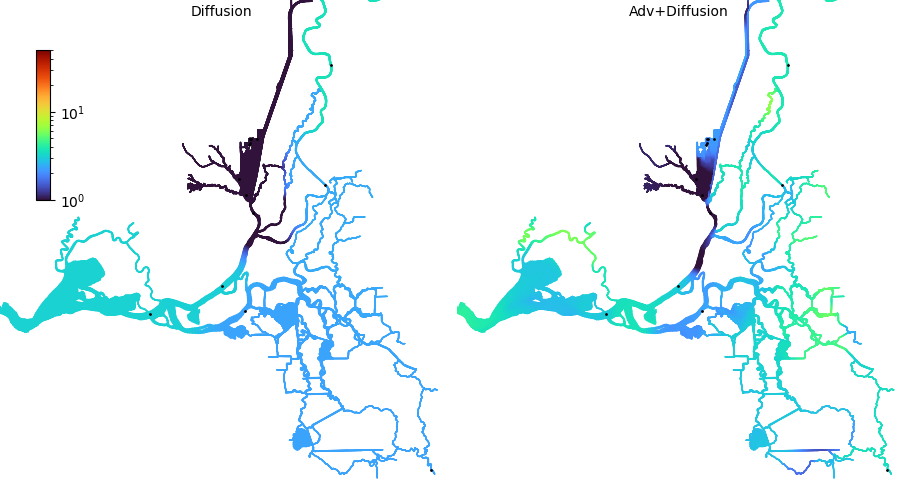

Checking finite geometry
Checking finite geometry


In [82]:

g=map_ds.grid

zoom=(570210., 651279., 4177852., 4269280.)
fig,axs=plt.subplots(1,2,figsize=(9.0,5.0))
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.03)
cax=fig.add_axes([0.04,0.6,0.016,0.3])


if 0:
    frame_dir=os.path.join(fig_dir,f'frames-{analyte}')
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    tidxs=range(1300,1500)
else:
    frame_dir=None
    tidxs=[1400]

for frame,tidx in enumerate(tidxs):
    if frame_dir is not None:
        img_fn=os.path.join(frame_dir,f'frame-{frame:04d}.png')
        if os.path.exists(img_fn):
            continue
        
    for ax,pred,label in zip(axs,
                             [diff_predictor,ad_predictor],
                             ['Diffusion','Adv+Diffusion']):
        ax.cla()
        ax.axis('off')
        ax.set_adjustable('datalim')

        scal=pred.predict_map(map_ds.time.values[tidx])

        missing=np.isnan(scal)
        ccoll=g.plot_cells(values=scal,cmap='turbo',ax=ax,lw=0.8,edgecolor='face',mask=~missing)
        g.plot_cells(mask=missing,color="0.8",ax=ax,lw=0.5,edgecolor='face')
        ccoll.set_clim(clim)
        ccoll.set_norm(colors.LogNorm(vmin=clim[0],vmax=clim[1]))

        # Show station locations
        ax.plot( mon_ds.x, mon_ds.y, 'k.', ms=2)
        ax.text(0.5,0.99,label,transform=ax.transAxes,ha='center',va='top')
        #for i,site in enumerate(mon_ds.site.values):
        #    ax.text(mon_ds.x[i], mon_ds.y[i], site, clip_on=True)

        ax.axis(zoom)

    cax.cla()
    plt.colorbar(ccoll,cax=cax)

    if frame_dir is not None:
        fig.savefig(img_fn)

In [45]:
pnt_franks_tract = [622900, 4211500]

In [26]:
from stompy.plot import mkanim

anim_fn=os.path.join(frame_dir,'movie.mp4')

mkanim.mkanim(out=anim_fn,
              frame_path=os.path.join(frame_dir,'frame-%04d.png'),
              fps=10)


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-0)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1692995742547/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1692995742547/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1692995742547/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1692995742547/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1692995742547/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav

In [28]:
display.Video(anim_fn)

While the adv-diffusion based reconstruction has a lower $r$ than the diffusion result, it degrades more gracefully far from observations. Diffusion alone has no "memory" and large portions of the domain can
have predictions that fluctuate over a short time scales.

In [83]:
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte)
diff_result=diff_predictor.predict_underway(cruise_df_thin)

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00
Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00


INFO:utils:7


Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00
Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:

INFO:utils:29


Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00
Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:

INFO:utils:51


Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00
Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:

INFO:utils:71


Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00
Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:

INFO:utils:90


Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00
Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:

INFO:utils:110


Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


In [85]:
ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=1e-5,min_weight=0.5)
ad_result=ad_predictor.predict_underway(cruise_df_thin)

Processing 2018-05-15T15:00:00 -- 2018-05-15T16:00:00
Checking finite geometry
Processing 2018-05-15T16:00:00 -- 2018-05-15T17:00:00
Processing 2018-05-15T17:00:00 -- 2018-05-15T18:00:00
Processing 2018-05-15T18:00:00 -- 2018-05-15T19:00:00
Processing 2018-05-15T19:00:00 -- 2018-05-15T20:00:00


INFO:utils:5


Processing 2018-05-15T20:00:00 -- 2018-05-15T21:00:00
Processing 2018-05-15T21:00:00 -- 2018-05-15T22:00:00
Processing 2018-05-15T22:00:00 -- 2018-05-15T23:00:00
Processing 2018-05-15T23:00:00 -- 2018-05-16T00:00:00
Processing 2018-05-16T00:00:00 -- 2018-05-16T01:00:00
Processing 2018-05-16T15:00:00 -- 2018-05-16T16:00:00
Processing 2018-05-16T16:00:00 -- 2018-05-16T17:00:00
Processing 2018-05-16T17:00:00 -- 2018-05-16T18:00:00
Processing 2018-05-16T18:00:00 -- 2018-05-16T19:00:00
Processing 2018-05-16T19:00:00 -- 2018-05-16T20:00:00
Processing 2018-05-16T20:00:00 -- 2018-05-16T21:00:00
Processing 2018-05-16T21:00:00 -- 2018-05-16T22:00:00
Processing 2018-05-16T22:00:00 -- 2018-05-16T23:00:00
Processing 2018-05-16T23:00:00 -- 2018-05-17T00:00:00
Processing 2018-05-17T00:00:00 -- 2018-05-17T01:00:00
Processing 2018-05-17T15:00:00 -- 2018-05-17T16:00:00
Processing 2018-05-17T16:00:00 -- 2018-05-17T17:00:00


INFO:utils:22


Processing 2018-05-17T17:00:00 -- 2018-05-17T18:00:00
Processing 2018-05-17T18:00:00 -- 2018-05-17T19:00:00
Processing 2018-05-17T19:00:00 -- 2018-05-17T20:00:00
Processing 2018-05-17T20:00:00 -- 2018-05-17T21:00:00
Processing 2018-05-17T21:00:00 -- 2018-05-17T22:00:00
Processing 2018-05-17T22:00:00 -- 2018-05-17T23:00:00
Processing 2018-05-17T23:00:00 -- 2018-05-18T00:00:00
Processing 2018-05-18T00:00:00 -- 2018-05-18T01:00:00
Processing 2018-07-24T14:00:00 -- 2018-07-24T15:00:00
Processing 2018-07-24T15:00:00 -- 2018-07-24T16:00:00
Processing 2018-07-24T16:00:00 -- 2018-07-24T17:00:00
Processing 2018-07-24T17:00:00 -- 2018-07-24T18:00:00
Processing 2018-07-24T18:00:00 -- 2018-07-24T19:00:00
Processing 2018-07-24T19:00:00 -- 2018-07-24T20:00:00
Processing 2018-07-24T20:00:00 -- 2018-07-24T21:00:00
Processing 2018-07-24T21:00:00 -- 2018-07-24T22:00:00
Processing 2018-07-24T22:00:00 -- 2018-07-24T23:00:00
Processing 2018-07-24T23:00:00 -- 2018-07-25T00:00:00


INFO:utils:40


Processing 2018-07-25T00:00:00 -- 2018-07-25T01:00:00
Processing 2018-07-25T01:00:00 -- 2018-07-25T02:00:00
Processing 2018-07-25T02:00:00 -- 2018-07-25T03:00:00
Processing 2018-07-25T14:00:00 -- 2018-07-25T15:00:00
Processing 2018-07-25T15:00:00 -- 2018-07-25T16:00:00
Processing 2018-07-25T16:00:00 -- 2018-07-25T17:00:00
Processing 2018-07-25T17:00:00 -- 2018-07-25T18:00:00
Processing 2018-07-25T18:00:00 -- 2018-07-25T19:00:00
Processing 2018-07-25T19:00:00 -- 2018-07-25T20:00:00
Processing 2018-07-25T20:00:00 -- 2018-07-25T21:00:00
Processing 2018-07-25T21:00:00 -- 2018-07-25T22:00:00
Processing 2018-07-25T22:00:00 -- 2018-07-25T23:00:00
Processing 2018-07-25T23:00:00 -- 2018-07-26T00:00:00
Processing 2018-07-26T00:00:00 -- 2018-07-26T01:00:00
Processing 2018-07-26T15:00:00 -- 2018-07-26T16:00:00
Processing 2018-07-26T16:00:00 -- 2018-07-26T17:00:00


INFO:utils:56


Processing 2018-07-26T17:00:00 -- 2018-07-26T18:00:00
Processing 2018-07-26T18:00:00 -- 2018-07-26T19:00:00
Processing 2018-07-26T19:00:00 -- 2018-07-26T20:00:00
Processing 2018-07-26T20:00:00 -- 2018-07-26T21:00:00
Processing 2018-07-26T21:00:00 -- 2018-07-26T22:00:00
Processing 2018-07-26T22:00:00 -- 2018-07-26T23:00:00
Processing 2018-07-26T23:00:00 -- 2018-07-27T00:00:00
Processing 2018-08-23T16:00:00 -- 2018-08-23T17:00:00
Processing 2018-08-23T17:00:00 -- 2018-08-23T18:00:00
Processing 2018-08-23T18:00:00 -- 2018-08-23T19:00:00
Processing 2018-08-23T19:00:00 -- 2018-08-23T20:00:00
Processing 2018-08-23T20:00:00 -- 2018-08-23T21:00:00
Processing 2018-08-23T21:00:00 -- 2018-08-23T22:00:00
Processing 2018-08-23T22:00:00 -- 2018-08-23T23:00:00
Processing 2018-08-23T23:00:00 -- 2018-08-24T00:00:00
Processing 2018-08-24T00:00:00 -- 2018-08-24T01:00:00
Processing 2018-09-05T15:00:00 -- 2018-09-05T16:00:00
Processing 2018-09-05T16:00:00 -- 2018-09-05T17:00:00


INFO:utils:74


Processing 2018-09-05T17:00:00 -- 2018-09-05T18:00:00
Processing 2018-09-05T18:00:00 -- 2018-09-05T19:00:00
Processing 2018-09-05T19:00:00 -- 2018-09-05T20:00:00
Processing 2018-09-05T20:00:00 -- 2018-09-05T21:00:00
Processing 2018-09-05T21:00:00 -- 2018-09-05T22:00:00
Processing 2018-09-05T22:00:00 -- 2018-09-05T23:00:00
Processing 2018-09-05T23:00:00 -- 2018-09-06T00:00:00
Processing 2018-09-13T18:00:00 -- 2018-09-13T19:00:00
Processing 2018-09-13T19:00:00 -- 2018-09-13T20:00:00
Processing 2018-09-13T20:00:00 -- 2018-09-13T21:00:00
Processing 2018-09-13T21:00:00 -- 2018-09-13T22:00:00
Processing 2018-09-13T22:00:00 -- 2018-09-13T23:00:00
Processing 2018-09-13T23:00:00 -- 2018-09-14T00:00:00
Processing 2018-09-14T00:00:00 -- 2018-09-14T01:00:00
Processing 2018-10-04T16:00:00 -- 2018-10-04T17:00:00
Processing 2018-10-04T17:00:00 -- 2018-10-04T18:00:00
Processing 2018-10-04T18:00:00 -- 2018-10-04T19:00:00
Processing 2018-10-04T19:00:00 -- 2018-10-04T20:00:00


INFO:utils:92


Processing 2018-10-17T16:00:00 -- 2018-10-17T17:00:00
Processing 2018-10-17T17:00:00 -- 2018-10-17T18:00:00
Processing 2018-10-17T18:00:00 -- 2018-10-17T19:00:00
Processing 2018-10-17T19:00:00 -- 2018-10-17T20:00:00
Processing 2018-10-17T20:00:00 -- 2018-10-17T21:00:00
Processing 2018-10-17T21:00:00 -- 2018-10-17T22:00:00
Processing 2018-10-17T22:00:00 -- 2018-10-17T23:00:00
Processing 2018-10-17T23:00:00 -- 2018-10-18T00:00:00
Processing 2018-10-18T00:00:00 -- 2018-10-18T01:00:00
Processing 2018-10-18T01:00:00 -- 2018-10-18T02:00:00
Processing 2018-10-18T15:00:00 -- 2018-10-18T16:00:00
Processing 2018-10-18T16:00:00 -- 2018-10-18T17:00:00
Processing 2018-10-18T17:00:00 -- 2018-10-18T18:00:00
Processing 2018-10-18T18:00:00 -- 2018-10-18T19:00:00
Processing 2018-10-18T19:00:00 -- 2018-10-18T20:00:00
Processing 2018-10-18T20:00:00 -- 2018-10-18T21:00:00
Processing 2018-10-18T21:00:00 -- 2018-10-18T22:00:00
Processing 2018-10-18T22:00:00 -- 2018-10-18T23:00:00


INFO:utils:110


Processing 2018-10-18T23:00:00 -- 2018-10-19T00:00:00
Processing 2018-10-19T14:00:00 -- 2018-10-19T15:00:00
Processing 2018-10-19T15:00:00 -- 2018-10-19T16:00:00
Processing 2018-10-19T16:00:00 -- 2018-10-19T17:00:00
Processing 2018-10-19T17:00:00 -- 2018-10-19T18:00:00
Processing 2018-10-19T18:00:00 -- 2018-10-19T19:00:00
Processing 2018-10-19T19:00:00 -- 2018-10-19T20:00:00
Processing 2018-10-19T20:00:00 -- 2018-10-19T21:00:00
Processing 2018-10-19T21:00:00 -- 2018-10-19T22:00:00
Processing 2018-10-19T22:00:00 -- 2018-10-19T23:00:00
Processing 2018-10-19T23:00:00 -- 2018-10-20T00:00:00
Processing 2018-10-20T00:00:00 -- 2018-10-20T01:00:00


<IPython.core.display.Javascript object>


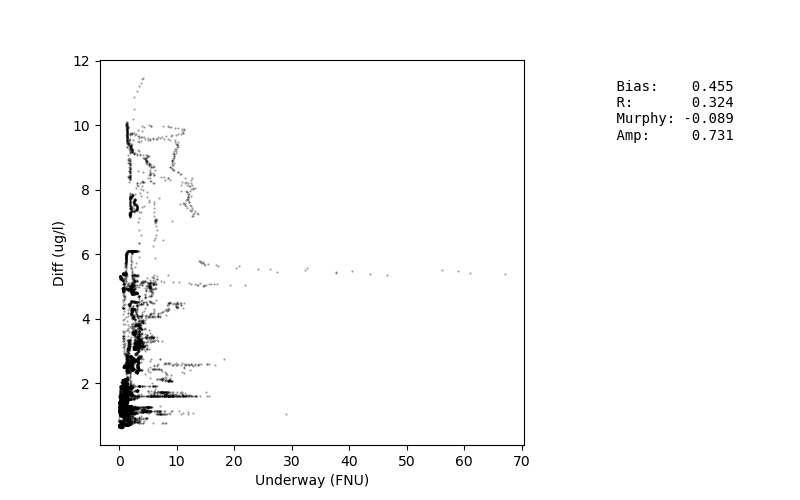

<IPython.core.display.Javascript object>


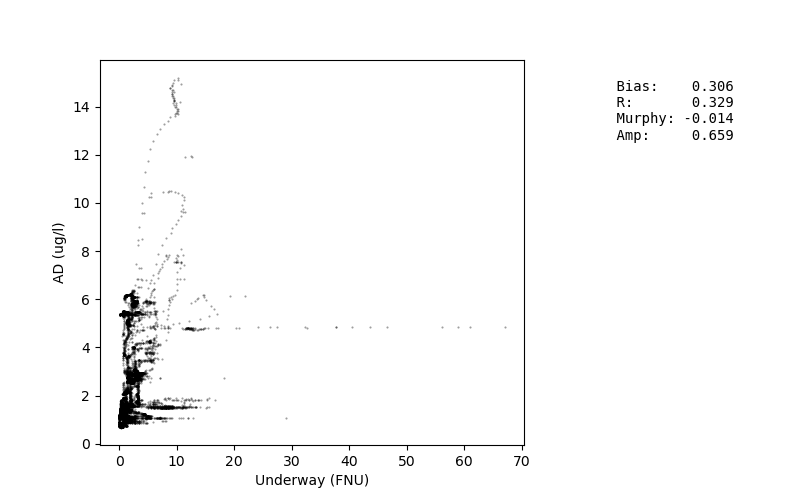

In [86]:
# TURB
#   For reference, straight diffusion from the observations is R=0.836, Amp=1.05 for tu

# R=0.831, Amp=0.978 for min_weight=0.9
# R=0.836, Amp=0.923 for min_weight=0.8
# R=0.837, Amp=0.824 for min_weight=0.5
# R=0.814, Amp=0.716 for 

# COND

# R: 0.989 for diffusion, 0.984 for AD
#  very similar murphy. Amplitudes were on either side of 1.0, 
#  fairly comparable.

# CHL

# R: 0.324 for diffusion, 0.329 for AD
#  murphy -0.89 vs. -0.014
# so neither are that great.

#valid = np.isfinite(ad_result + diff_result)
#extrap_evaluate(ad_result[valid],   cruise_df_thin['turb'].values[valid], label='Adv-diff (FNU)')
fig1=extrap_evaluate(diff_result, cruise_df_thin[analyte], label=f'Diff ({units})')

fig2=extrap_evaluate(ad_result, cruise_df_thin[analyte], label=f'AD ({units})')

# Double checking later analysis of 2018-07-25 to the global results.
#cruise_sel=(cruise_df_thin.date.values==np.datetime64('2018-07-25'))
#fig.axes[0].lines[0].set_ms(10)
#fig.axes[0].plot( cruise_df_thin['turb'].values[cruise_sel], diff_result[cruise_sel],
#                 'r.', alpha=0.5)



Extrapolation based on the past measurements advected forward does not improve the predictive
skill. Isolated features, such as a pulse of turbid waters injected into Franks Tract, demonstrate
the concept, but on the whole skill is worse for turbidity. 

For conductivity the gradients are smaller, with less local variability. Both methods
attain high correlation, almost identical.

For chlorophyll the drivers are less obviously spatial, and neither method is very good.
AD is marginally better.

In [87]:
# Show time series from the two methods at a point in Franks Tract, hopefully demonstrating
# how advection brings in a memory component.
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=mon_ds,mon_field=analyte)
ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal=analyte,alpha=1e-5,min_weight=0.5)

franks_df=pd.DataFrame()
franks_df['time'] = map_ds.time.values[1200:1400]
franks_df['x']=pnt_franks_tract[0]
franks_df['y']=pnt_franks_tract[1]

ad_result=ad_predictor.predict_underway(franks_df)
diff_result=diff_predictor.predict_underway(franks_df)

Processing 2018-05-21T00:00:00 -- 2018-05-21T01:00:00
Checking finite geometry
Processing 2018-05-21T01:00:00 -- 2018-05-21T02:00:00
Processing 2018-05-21T02:00:00 -- 2018-05-21T03:00:00
Processing 2018-05-21T03:00:00 -- 2018-05-21T04:00:00
Processing 2018-05-21T04:00:00 -- 2018-05-21T05:00:00


INFO:utils:5


Processing 2018-05-21T05:00:00 -- 2018-05-21T06:00:00
Processing 2018-05-21T06:00:00 -- 2018-05-21T07:00:00
Processing 2018-05-21T07:00:00 -- 2018-05-21T08:00:00
Processing 2018-05-21T08:00:00 -- 2018-05-21T09:00:00
Processing 2018-05-21T09:00:00 -- 2018-05-21T10:00:00
Processing 2018-05-21T10:00:00 -- 2018-05-21T11:00:00
Processing 2018-05-21T11:00:00 -- 2018-05-21T12:00:00
Processing 2018-05-21T12:00:00 -- 2018-05-21T13:00:00
Processing 2018-05-21T13:00:00 -- 2018-05-21T14:00:00
Processing 2018-05-21T14:00:00 -- 2018-05-21T15:00:00
Processing 2018-05-21T15:00:00 -- 2018-05-21T16:00:00
Processing 2018-05-21T16:00:00 -- 2018-05-21T17:00:00
Processing 2018-05-21T17:00:00 -- 2018-05-21T18:00:00
Processing 2018-05-21T18:00:00 -- 2018-05-21T19:00:00
Processing 2018-05-21T19:00:00 -- 2018-05-21T20:00:00
Processing 2018-05-21T20:00:00 -- 2018-05-21T21:00:00
Processing 2018-05-21T21:00:00 -- 2018-05-21T22:00:00
Processing 2018-05-21T22:00:00 -- 2018-05-21T23:00:00
Processing 2018-05-21T23:00:

INFO:utils:25


Processing 2018-05-22T01:00:00 -- 2018-05-22T02:00:00
Processing 2018-05-22T02:00:00 -- 2018-05-22T03:00:00
Processing 2018-05-22T03:00:00 -- 2018-05-22T04:00:00
Processing 2018-05-22T04:00:00 -- 2018-05-22T05:00:00
Processing 2018-05-22T05:00:00 -- 2018-05-22T06:00:00
Processing 2018-05-22T06:00:00 -- 2018-05-22T07:00:00
Processing 2018-05-22T07:00:00 -- 2018-05-22T08:00:00
Processing 2018-05-22T08:00:00 -- 2018-05-22T09:00:00
Processing 2018-05-22T09:00:00 -- 2018-05-22T10:00:00
Processing 2018-05-22T10:00:00 -- 2018-05-22T11:00:00
Processing 2018-05-22T11:00:00 -- 2018-05-22T12:00:00
Processing 2018-05-22T12:00:00 -- 2018-05-22T13:00:00
Processing 2018-05-22T13:00:00 -- 2018-05-22T14:00:00
Processing 2018-05-22T14:00:00 -- 2018-05-22T15:00:00
Processing 2018-05-22T15:00:00 -- 2018-05-22T16:00:00
Processing 2018-05-22T16:00:00 -- 2018-05-22T17:00:00
Processing 2018-05-22T17:00:00 -- 2018-05-22T18:00:00
Processing 2018-05-22T18:00:00 -- 2018-05-22T19:00:00
Processing 2018-05-22T19:00:

INFO:utils:45


Processing 2018-05-22T21:00:00 -- 2018-05-22T22:00:00
Processing 2018-05-22T22:00:00 -- 2018-05-22T23:00:00
Processing 2018-05-22T23:00:00 -- 2018-05-23T00:00:00
Processing 2018-05-23T00:00:00 -- 2018-05-23T01:00:00
Processing 2018-05-23T01:00:00 -- 2018-05-23T02:00:00
Processing 2018-05-23T02:00:00 -- 2018-05-23T03:00:00
Processing 2018-05-23T03:00:00 -- 2018-05-23T04:00:00
Processing 2018-05-23T04:00:00 -- 2018-05-23T05:00:00
Processing 2018-05-23T05:00:00 -- 2018-05-23T06:00:00
Processing 2018-05-23T06:00:00 -- 2018-05-23T07:00:00
Processing 2018-05-23T07:00:00 -- 2018-05-23T08:00:00
Processing 2018-05-23T08:00:00 -- 2018-05-23T09:00:00
Processing 2018-05-23T09:00:00 -- 2018-05-23T10:00:00
Processing 2018-05-23T10:00:00 -- 2018-05-23T11:00:00
Processing 2018-05-23T11:00:00 -- 2018-05-23T12:00:00
Processing 2018-05-23T12:00:00 -- 2018-05-23T13:00:00
Processing 2018-05-23T13:00:00 -- 2018-05-23T14:00:00
Processing 2018-05-23T14:00:00 -- 2018-05-23T15:00:00
Processing 2018-05-23T15:00:

INFO:utils:66


Processing 2018-05-23T18:00:00 -- 2018-05-23T19:00:00
Processing 2018-05-23T19:00:00 -- 2018-05-23T20:00:00
Processing 2018-05-23T20:00:00 -- 2018-05-23T21:00:00
Processing 2018-05-23T21:00:00 -- 2018-05-23T22:00:00
Processing 2018-05-23T22:00:00 -- 2018-05-23T23:00:00
Processing 2018-05-23T23:00:00 -- 2018-05-24T00:00:00
Processing 2018-05-24T00:00:00 -- 2018-05-24T01:00:00
Processing 2018-05-24T01:00:00 -- 2018-05-24T02:00:00
Processing 2018-05-24T02:00:00 -- 2018-05-24T03:00:00
Processing 2018-05-24T03:00:00 -- 2018-05-24T04:00:00
Processing 2018-05-24T04:00:00 -- 2018-05-24T05:00:00
Processing 2018-05-24T05:00:00 -- 2018-05-24T06:00:00
Processing 2018-05-24T06:00:00 -- 2018-05-24T07:00:00
Processing 2018-05-24T07:00:00 -- 2018-05-24T08:00:00
Processing 2018-05-24T08:00:00 -- 2018-05-24T09:00:00
Processing 2018-05-24T09:00:00 -- 2018-05-24T10:00:00
Processing 2018-05-24T10:00:00 -- 2018-05-24T11:00:00
Processing 2018-05-24T11:00:00 -- 2018-05-24T12:00:00
Processing 2018-05-24T12:00:

INFO:utils:87


Processing 2018-05-24T15:00:00 -- 2018-05-24T16:00:00
Processing 2018-05-24T16:00:00 -- 2018-05-24T17:00:00
Processing 2018-05-24T17:00:00 -- 2018-05-24T18:00:00
Processing 2018-05-24T18:00:00 -- 2018-05-24T19:00:00
Processing 2018-05-24T19:00:00 -- 2018-05-24T20:00:00
Processing 2018-05-24T20:00:00 -- 2018-05-24T21:00:00
Processing 2018-05-24T21:00:00 -- 2018-05-24T22:00:00
Processing 2018-05-24T22:00:00 -- 2018-05-24T23:00:00
Processing 2018-05-24T23:00:00 -- 2018-05-25T00:00:00
Processing 2018-05-25T00:00:00 -- 2018-05-25T01:00:00
Processing 2018-05-25T01:00:00 -- 2018-05-25T02:00:00
Processing 2018-05-25T02:00:00 -- 2018-05-25T03:00:00
Processing 2018-05-25T03:00:00 -- 2018-05-25T04:00:00
Processing 2018-05-25T04:00:00 -- 2018-05-25T05:00:00
Processing 2018-05-25T05:00:00 -- 2018-05-25T06:00:00
Processing 2018-05-25T06:00:00 -- 2018-05-25T07:00:00
Processing 2018-05-25T07:00:00 -- 2018-05-25T08:00:00
Processing 2018-05-25T08:00:00 -- 2018-05-25T09:00:00
Processing 2018-05-25T09:00:

INFO:utils:108


Processing 2018-05-25T12:00:00 -- 2018-05-25T13:00:00
Processing 2018-05-25T13:00:00 -- 2018-05-25T14:00:00
Processing 2018-05-25T14:00:00 -- 2018-05-25T15:00:00
Processing 2018-05-25T15:00:00 -- 2018-05-25T16:00:00
Processing 2018-05-25T16:00:00 -- 2018-05-25T17:00:00
Processing 2018-05-25T17:00:00 -- 2018-05-25T18:00:00
Processing 2018-05-25T18:00:00 -- 2018-05-25T19:00:00
Processing 2018-05-25T19:00:00 -- 2018-05-25T20:00:00
Processing 2018-05-25T20:00:00 -- 2018-05-25T21:00:00
Processing 2018-05-25T21:00:00 -- 2018-05-25T22:00:00
Processing 2018-05-25T22:00:00 -- 2018-05-25T23:00:00
Processing 2018-05-25T23:00:00 -- 2018-05-26T00:00:00
Processing 2018-05-26T00:00:00 -- 2018-05-26T01:00:00
Processing 2018-05-26T01:00:00 -- 2018-05-26T02:00:00
Processing 2018-05-26T02:00:00 -- 2018-05-26T03:00:00
Processing 2018-05-26T03:00:00 -- 2018-05-26T04:00:00
Processing 2018-05-26T04:00:00 -- 2018-05-26T05:00:00
Processing 2018-05-26T05:00:00 -- 2018-05-26T06:00:00
Processing 2018-05-26T06:00:

INFO:utils:129


Processing 2018-05-26T09:00:00 -- 2018-05-26T10:00:00
Processing 2018-05-26T10:00:00 -- 2018-05-26T11:00:00
Processing 2018-05-26T11:00:00 -- 2018-05-26T12:00:00
Processing 2018-05-26T12:00:00 -- 2018-05-26T13:00:00
Processing 2018-05-26T13:00:00 -- 2018-05-26T14:00:00
Processing 2018-05-26T14:00:00 -- 2018-05-26T15:00:00
Processing 2018-05-26T15:00:00 -- 2018-05-26T16:00:00
Processing 2018-05-26T16:00:00 -- 2018-05-26T17:00:00
Processing 2018-05-26T17:00:00 -- 2018-05-26T18:00:00
Processing 2018-05-26T18:00:00 -- 2018-05-26T19:00:00
Processing 2018-05-26T19:00:00 -- 2018-05-26T20:00:00
Processing 2018-05-26T20:00:00 -- 2018-05-26T21:00:00
Processing 2018-05-26T21:00:00 -- 2018-05-26T22:00:00
Processing 2018-05-26T22:00:00 -- 2018-05-26T23:00:00
Processing 2018-05-26T23:00:00 -- 2018-05-27T00:00:00
Processing 2018-05-27T00:00:00 -- 2018-05-27T01:00:00
Processing 2018-05-27T01:00:00 -- 2018-05-27T02:00:00
Processing 2018-05-27T02:00:00 -- 2018-05-27T03:00:00
Processing 2018-05-27T03:00:

INFO:utils:149


Processing 2018-05-27T05:00:00 -- 2018-05-27T06:00:00
Processing 2018-05-27T06:00:00 -- 2018-05-27T07:00:00
Processing 2018-05-27T07:00:00 -- 2018-05-27T08:00:00
Processing 2018-05-27T08:00:00 -- 2018-05-27T09:00:00
Processing 2018-05-27T09:00:00 -- 2018-05-27T10:00:00
Processing 2018-05-27T10:00:00 -- 2018-05-27T11:00:00
Processing 2018-05-27T11:00:00 -- 2018-05-27T12:00:00
Processing 2018-05-27T12:00:00 -- 2018-05-27T13:00:00
Processing 2018-05-27T13:00:00 -- 2018-05-27T14:00:00
Processing 2018-05-27T14:00:00 -- 2018-05-27T15:00:00
Processing 2018-05-27T15:00:00 -- 2018-05-27T16:00:00
Processing 2018-05-27T16:00:00 -- 2018-05-27T17:00:00
Processing 2018-05-27T17:00:00 -- 2018-05-27T18:00:00
Processing 2018-05-27T18:00:00 -- 2018-05-27T19:00:00
Processing 2018-05-27T19:00:00 -- 2018-05-27T20:00:00
Processing 2018-05-27T20:00:00 -- 2018-05-27T21:00:00
Processing 2018-05-27T21:00:00 -- 2018-05-27T22:00:00
Processing 2018-05-27T22:00:00 -- 2018-05-27T23:00:00
Processing 2018-05-27T23:00:

INFO:utils:170


Processing 2018-05-28T02:00:00 -- 2018-05-28T03:00:00
Processing 2018-05-28T03:00:00 -- 2018-05-28T04:00:00
Processing 2018-05-28T04:00:00 -- 2018-05-28T05:00:00
Processing 2018-05-28T05:00:00 -- 2018-05-28T06:00:00
Processing 2018-05-28T06:00:00 -- 2018-05-28T07:00:00
Processing 2018-05-28T07:00:00 -- 2018-05-28T08:00:00
Processing 2018-05-28T08:00:00 -- 2018-05-28T09:00:00
Processing 2018-05-28T09:00:00 -- 2018-05-28T10:00:00
Processing 2018-05-28T10:00:00 -- 2018-05-28T11:00:00
Processing 2018-05-28T11:00:00 -- 2018-05-28T12:00:00
Processing 2018-05-28T12:00:00 -- 2018-05-28T13:00:00
Processing 2018-05-28T13:00:00 -- 2018-05-28T14:00:00
Processing 2018-05-28T14:00:00 -- 2018-05-28T15:00:00
Processing 2018-05-28T15:00:00 -- 2018-05-28T16:00:00
Processing 2018-05-28T16:00:00 -- 2018-05-28T17:00:00
Processing 2018-05-28T17:00:00 -- 2018-05-28T18:00:00
Processing 2018-05-28T18:00:00 -- 2018-05-28T19:00:00
Processing 2018-05-28T19:00:00 -- 2018-05-28T20:00:00
Processing 2018-05-28T20:00:

INFO:utils:190


Processing 2018-05-28T22:00:00 -- 2018-05-28T23:00:00
Processing 2018-05-28T23:00:00 -- 2018-05-29T00:00:00
Processing 2018-05-29T00:00:00 -- 2018-05-29T01:00:00
Processing 2018-05-29T01:00:00 -- 2018-05-29T02:00:00
Processing 2018-05-29T02:00:00 -- 2018-05-29T03:00:00
Processing 2018-05-29T03:00:00 -- 2018-05-29T04:00:00
Processing 2018-05-29T04:00:00 -- 2018-05-29T05:00:00
Processing 2018-05-29T05:00:00 -- 2018-05-29T06:00:00
Processing 2018-05-29T06:00:00 -- 2018-05-29T07:00:00
Processing 2018-05-29T07:00:00 -- 2018-05-29T08:00:00
Processing 2018-05-21T00:00:00 -- 2018-05-21T01:00:00
Checking finite geometry
Processing 2018-05-21T01:00:00 -- 2018-05-21T02:00:00
Processing 2018-05-21T02:00:00 -- 2018-05-21T03:00:00
Processing 2018-05-21T03:00:00 -- 2018-05-21T04:00:00
Processing 2018-05-21T04:00:00 -- 2018-05-21T05:00:00
Processing 2018-05-21T05:00:00 -- 2018-05-21T06:00:00


INFO:utils:6


Processing 2018-05-21T06:00:00 -- 2018-05-21T07:00:00
Processing 2018-05-21T07:00:00 -- 2018-05-21T08:00:00
Processing 2018-05-21T08:00:00 -- 2018-05-21T09:00:00
Processing 2018-05-21T09:00:00 -- 2018-05-21T10:00:00
Processing 2018-05-21T10:00:00 -- 2018-05-21T11:00:00
Processing 2018-05-21T11:00:00 -- 2018-05-21T12:00:00
Processing 2018-05-21T12:00:00 -- 2018-05-21T13:00:00
Processing 2018-05-21T13:00:00 -- 2018-05-21T14:00:00
Processing 2018-05-21T14:00:00 -- 2018-05-21T15:00:00
Processing 2018-05-21T15:00:00 -- 2018-05-21T16:00:00
Processing 2018-05-21T16:00:00 -- 2018-05-21T17:00:00
Processing 2018-05-21T17:00:00 -- 2018-05-21T18:00:00
Processing 2018-05-21T18:00:00 -- 2018-05-21T19:00:00
Processing 2018-05-21T19:00:00 -- 2018-05-21T20:00:00
Processing 2018-05-21T20:00:00 -- 2018-05-21T21:00:00
Processing 2018-05-21T21:00:00 -- 2018-05-21T22:00:00
Processing 2018-05-21T22:00:00 -- 2018-05-21T23:00:00
Processing 2018-05-21T23:00:00 -- 2018-05-22T00:00:00
Processing 2018-05-22T00:00:

INFO:utils:30


Processing 2018-05-22T06:00:00 -- 2018-05-22T07:00:00
Processing 2018-05-22T07:00:00 -- 2018-05-22T08:00:00
Processing 2018-05-22T08:00:00 -- 2018-05-22T09:00:00
Processing 2018-05-22T09:00:00 -- 2018-05-22T10:00:00
Processing 2018-05-22T10:00:00 -- 2018-05-22T11:00:00
Processing 2018-05-22T11:00:00 -- 2018-05-22T12:00:00
Processing 2018-05-22T12:00:00 -- 2018-05-22T13:00:00
Processing 2018-05-22T13:00:00 -- 2018-05-22T14:00:00
Processing 2018-05-22T14:00:00 -- 2018-05-22T15:00:00
Processing 2018-05-22T15:00:00 -- 2018-05-22T16:00:00
Processing 2018-05-22T16:00:00 -- 2018-05-22T17:00:00
Processing 2018-05-22T17:00:00 -- 2018-05-22T18:00:00
Processing 2018-05-22T18:00:00 -- 2018-05-22T19:00:00
Processing 2018-05-22T19:00:00 -- 2018-05-22T20:00:00
Processing 2018-05-22T20:00:00 -- 2018-05-22T21:00:00
Processing 2018-05-22T21:00:00 -- 2018-05-22T22:00:00
Processing 2018-05-22T22:00:00 -- 2018-05-22T23:00:00
Processing 2018-05-22T23:00:00 -- 2018-05-23T00:00:00
Processing 2018-05-23T00:00:

INFO:utils:53


Processing 2018-05-23T05:00:00 -- 2018-05-23T06:00:00
Processing 2018-05-23T06:00:00 -- 2018-05-23T07:00:00
Processing 2018-05-23T07:00:00 -- 2018-05-23T08:00:00
Processing 2018-05-23T08:00:00 -- 2018-05-23T09:00:00
Processing 2018-05-23T09:00:00 -- 2018-05-23T10:00:00
Processing 2018-05-23T10:00:00 -- 2018-05-23T11:00:00
Processing 2018-05-23T11:00:00 -- 2018-05-23T12:00:00
Processing 2018-05-23T12:00:00 -- 2018-05-23T13:00:00
Processing 2018-05-23T13:00:00 -- 2018-05-23T14:00:00
Processing 2018-05-23T14:00:00 -- 2018-05-23T15:00:00
Processing 2018-05-23T15:00:00 -- 2018-05-23T16:00:00
Processing 2018-05-23T16:00:00 -- 2018-05-23T17:00:00
Processing 2018-05-23T17:00:00 -- 2018-05-23T18:00:00
Processing 2018-05-23T18:00:00 -- 2018-05-23T19:00:00
Processing 2018-05-23T19:00:00 -- 2018-05-23T20:00:00
Processing 2018-05-23T20:00:00 -- 2018-05-23T21:00:00
Processing 2018-05-23T21:00:00 -- 2018-05-23T22:00:00
Processing 2018-05-23T22:00:00 -- 2018-05-23T23:00:00
Processing 2018-05-23T23:00:

INFO:utils:77


Processing 2018-05-24T05:00:00 -- 2018-05-24T06:00:00
Processing 2018-05-24T06:00:00 -- 2018-05-24T07:00:00
Processing 2018-05-24T07:00:00 -- 2018-05-24T08:00:00
Processing 2018-05-24T08:00:00 -- 2018-05-24T09:00:00
Processing 2018-05-24T09:00:00 -- 2018-05-24T10:00:00
Processing 2018-05-24T10:00:00 -- 2018-05-24T11:00:00
Processing 2018-05-24T11:00:00 -- 2018-05-24T12:00:00
Processing 2018-05-24T12:00:00 -- 2018-05-24T13:00:00
Processing 2018-05-24T13:00:00 -- 2018-05-24T14:00:00
Processing 2018-05-24T14:00:00 -- 2018-05-24T15:00:00
Processing 2018-05-24T15:00:00 -- 2018-05-24T16:00:00
Processing 2018-05-24T16:00:00 -- 2018-05-24T17:00:00
Processing 2018-05-24T17:00:00 -- 2018-05-24T18:00:00
Processing 2018-05-24T18:00:00 -- 2018-05-24T19:00:00
Processing 2018-05-24T19:00:00 -- 2018-05-24T20:00:00
Processing 2018-05-24T20:00:00 -- 2018-05-24T21:00:00
Processing 2018-05-24T21:00:00 -- 2018-05-24T22:00:00
Processing 2018-05-24T22:00:00 -- 2018-05-24T23:00:00
Processing 2018-05-24T23:00:

INFO:utils:101


Processing 2018-05-25T05:00:00 -- 2018-05-25T06:00:00
Processing 2018-05-25T06:00:00 -- 2018-05-25T07:00:00
Processing 2018-05-25T07:00:00 -- 2018-05-25T08:00:00
Processing 2018-05-25T08:00:00 -- 2018-05-25T09:00:00
Processing 2018-05-25T09:00:00 -- 2018-05-25T10:00:00
Processing 2018-05-25T10:00:00 -- 2018-05-25T11:00:00
Processing 2018-05-25T11:00:00 -- 2018-05-25T12:00:00
Processing 2018-05-25T12:00:00 -- 2018-05-25T13:00:00
Processing 2018-05-25T13:00:00 -- 2018-05-25T14:00:00
Processing 2018-05-25T14:00:00 -- 2018-05-25T15:00:00
Processing 2018-05-25T15:00:00 -- 2018-05-25T16:00:00
Processing 2018-05-25T16:00:00 -- 2018-05-25T17:00:00
Processing 2018-05-25T17:00:00 -- 2018-05-25T18:00:00
Processing 2018-05-25T18:00:00 -- 2018-05-25T19:00:00
Processing 2018-05-25T19:00:00 -- 2018-05-25T20:00:00
Processing 2018-05-25T20:00:00 -- 2018-05-25T21:00:00
Processing 2018-05-25T21:00:00 -- 2018-05-25T22:00:00
Processing 2018-05-25T22:00:00 -- 2018-05-25T23:00:00
Processing 2018-05-25T23:00:

INFO:utils:126


Processing 2018-05-26T06:00:00 -- 2018-05-26T07:00:00
Processing 2018-05-26T07:00:00 -- 2018-05-26T08:00:00
Processing 2018-05-26T08:00:00 -- 2018-05-26T09:00:00
Processing 2018-05-26T09:00:00 -- 2018-05-26T10:00:00
Processing 2018-05-26T10:00:00 -- 2018-05-26T11:00:00
Processing 2018-05-26T11:00:00 -- 2018-05-26T12:00:00
Processing 2018-05-26T12:00:00 -- 2018-05-26T13:00:00
Processing 2018-05-26T13:00:00 -- 2018-05-26T14:00:00
Processing 2018-05-26T14:00:00 -- 2018-05-26T15:00:00
Processing 2018-05-26T15:00:00 -- 2018-05-26T16:00:00
Processing 2018-05-26T16:00:00 -- 2018-05-26T17:00:00
Processing 2018-05-26T17:00:00 -- 2018-05-26T18:00:00
Processing 2018-05-26T18:00:00 -- 2018-05-26T19:00:00
Processing 2018-05-26T19:00:00 -- 2018-05-26T20:00:00
Processing 2018-05-26T20:00:00 -- 2018-05-26T21:00:00
Processing 2018-05-26T21:00:00 -- 2018-05-26T22:00:00
Processing 2018-05-26T22:00:00 -- 2018-05-26T23:00:00
Processing 2018-05-26T23:00:00 -- 2018-05-27T00:00:00
Processing 2018-05-27T00:00:

INFO:utils:150


Processing 2018-05-27T06:00:00 -- 2018-05-27T07:00:00
Processing 2018-05-27T07:00:00 -- 2018-05-27T08:00:00
Processing 2018-05-27T08:00:00 -- 2018-05-27T09:00:00
Processing 2018-05-27T09:00:00 -- 2018-05-27T10:00:00
Processing 2018-05-27T10:00:00 -- 2018-05-27T11:00:00
Processing 2018-05-27T11:00:00 -- 2018-05-27T12:00:00
Processing 2018-05-27T12:00:00 -- 2018-05-27T13:00:00
Processing 2018-05-27T13:00:00 -- 2018-05-27T14:00:00
Processing 2018-05-27T14:00:00 -- 2018-05-27T15:00:00
Processing 2018-05-27T15:00:00 -- 2018-05-27T16:00:00
Processing 2018-05-27T16:00:00 -- 2018-05-27T17:00:00
Processing 2018-05-27T17:00:00 -- 2018-05-27T18:00:00
Processing 2018-05-27T18:00:00 -- 2018-05-27T19:00:00
Processing 2018-05-27T19:00:00 -- 2018-05-27T20:00:00
Processing 2018-05-27T20:00:00 -- 2018-05-27T21:00:00
Processing 2018-05-27T21:00:00 -- 2018-05-27T22:00:00
Processing 2018-05-27T22:00:00 -- 2018-05-27T23:00:00
Processing 2018-05-27T23:00:00 -- 2018-05-28T00:00:00
Processing 2018-05-28T00:00:

INFO:utils:174


Processing 2018-05-28T06:00:00 -- 2018-05-28T07:00:00
Processing 2018-05-28T07:00:00 -- 2018-05-28T08:00:00
Processing 2018-05-28T08:00:00 -- 2018-05-28T09:00:00
Processing 2018-05-28T09:00:00 -- 2018-05-28T10:00:00
Processing 2018-05-28T10:00:00 -- 2018-05-28T11:00:00
Processing 2018-05-28T11:00:00 -- 2018-05-28T12:00:00
Processing 2018-05-28T12:00:00 -- 2018-05-28T13:00:00
Processing 2018-05-28T13:00:00 -- 2018-05-28T14:00:00
Processing 2018-05-28T14:00:00 -- 2018-05-28T15:00:00
Processing 2018-05-28T15:00:00 -- 2018-05-28T16:00:00
Processing 2018-05-28T16:00:00 -- 2018-05-28T17:00:00
Processing 2018-05-28T17:00:00 -- 2018-05-28T18:00:00
Processing 2018-05-28T18:00:00 -- 2018-05-28T19:00:00
Processing 2018-05-28T19:00:00 -- 2018-05-28T20:00:00
Processing 2018-05-28T20:00:00 -- 2018-05-28T21:00:00
Processing 2018-05-28T21:00:00 -- 2018-05-28T22:00:00
Processing 2018-05-28T22:00:00 -- 2018-05-28T23:00:00
Processing 2018-05-28T23:00:00 -- 2018-05-29T00:00:00
Processing 2018-05-29T00:00:

INFO:utils:198


Processing 2018-05-29T06:00:00 -- 2018-05-29T07:00:00
Processing 2018-05-29T07:00:00 -- 2018-05-29T08:00:00


<IPython.core.display.Javascript object>


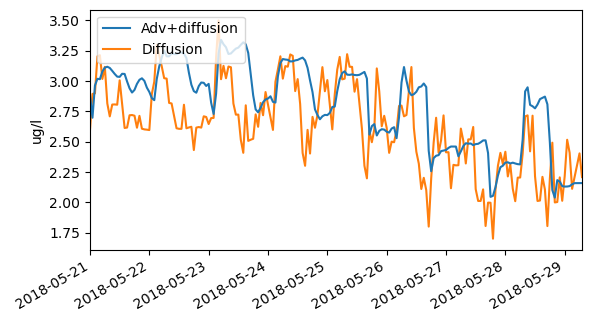

In [88]:
fig,ax=plt.subplots(figsize=[6,3.2])

ax.plot( franks_df.time, ad_result, label='Adv+diffusion')
ax.plot( franks_df.time, diff_result, label='Diffusion',zorder=-1)

ax.legend(loc='upper left')
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15,right=0.97,top=0.97,bottom=0.22)

ax.axis(xmin=franks_df.time.min(),xmax=franks_df.time.max())
ax.set_ylabel(units)
fig.savefig(os.path.join(fig_dir,f'timeseries-compare-franks_tracts-{analyte}.png'))

Diffusion, but with Hydrodynamic-derived Diffusion Coefficients
==

Can throw in various scalar fields, get pair-wise covariance or correlation estimates.

How to relate correlation to diffusion coefficient?

I think this is **Kriging**.



Predicting from Antecedent Bed Stress
==

In [22]:
# choose one of the july dates. 2018-07-25
cruise_df_thin.groupby(cruise_df_thin.time.dt.date).size()

time
2018-05-15     974
2018-05-16     956
2018-05-17     821
2018-05-18      31
2018-07-24     812
2018-07-25    1320
2018-07-26    1049
2018-08-23     861
2018-08-24      14
2018-09-05     838
2018-09-13     621
2018-09-14     107
2018-10-04     314
2018-10-17     922
2018-10-18    1055
2018-10-19    1088
2018-10-20      54
dtype: int64

<IPython.core.display.Javascript object>


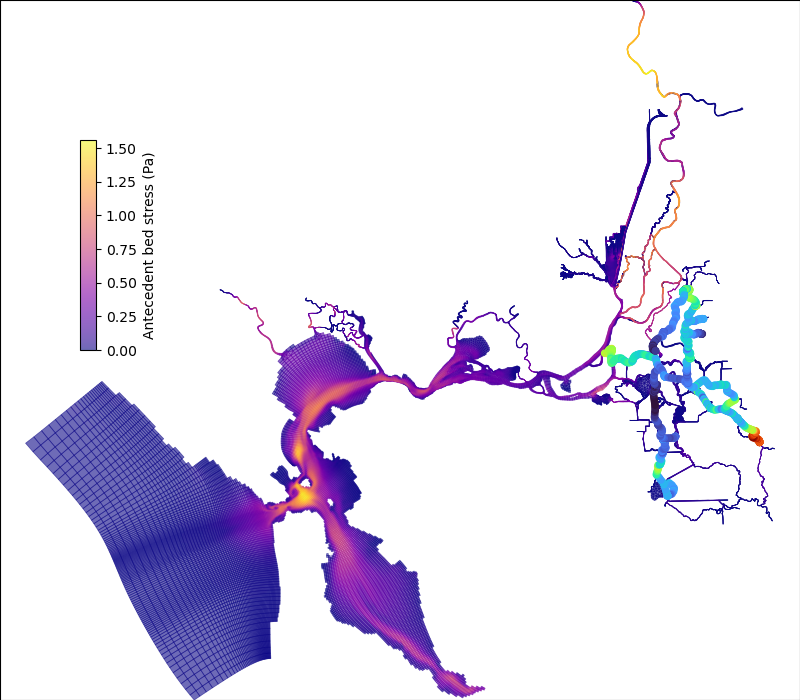

In [23]:
# First just check out the bed stress, 
# choose a snapshot from about the same time as a cruise
# Quick look is not promising.
# HERE: but do the extraction, plot a scatter.

snap=map_ds.sel(time=np.datetime64("2018-07-25 19:00"),method='nearest')
cruise_snap=cruise_df_thin[ cruise_df_thin.time.dt.date==np.datetime64("2018-07-25")]


fig,ax=plt.subplots(figsize=(8,7))
ax.set_adjustable('datalim')
ax.set_position([0,0,1,1])
cax=fig.add_axes([0.1,0.5,0.02,0.3])

tau=snap['mesh2d_tauDecay0'].values
ccoll=map_ds.grid.plot_cells(values=tau,cmap='plasma',lw=0.5,edgecolor='face',ax=ax,
                             alpha=0.6)

scat=ax.scatter(cruise_snap.x, cruise_snap.y, 20, cruise_snap['turb'], cmap='turbo')
plt.colorbar(ccoll,cax=cax,label='Antecedent bed stress (Pa)')

In [24]:
# Extract bed stress at time/location of each underway data point
# For starters keep it in one day so we're not getting a bunch of
# seasonal variation, too.

#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-25")]
#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-24")]
#cruise_snap=cruise_df_thin[ cruise_df_thin.date==np.datetime64("2018-07-26")]
cruise_snap=cruise_df_thin

map_times=map_ds.time.values

cruise_w_tau=cruise_snap.copy()
cruise_w_tau['tau']=np.nan
cruise_w_tau['tau0']=np.nan
cruise_w_tau['tau1']=np.nan
cruise_w_tau['pred_advd']=np.nan
cruise_w_tau['pred_diff']=np.nan
cruise_xy=cruise_w_tau[ ['x','y'] ].values

tidxs=np.searchsorted(map_times, cruise_snap.time.values)

ad_predictor=AdvDiffPredictor(map_ds=map_ds,scal='turb',alpha=1e-5)
diff_predictor=DiffusionPredictor(grid=map_ds.grid, mon_ds=turb_ds,mon_field='turbidity')

for tidx,grp in utils.enumerate_groups(tidxs):
    snap=map_ds.isel(time=tidx)
    cells=[map_ds.grid.select_cells_nearest(pnt)
           for pnt in cruise_xy[grp,:]]
    cruise_w_tau['tau'].values[grp]  = snap['mesh2d_taus'].values[cells]
    cruise_w_tau['tau0'].values[grp] = snap['mesh2d_tauDecay0'].values[cells]
    cruise_w_tau['tau1'].values[grp] = snap['mesh2d_tauDecay1'].values[cells]
    
    # Go ahead and populate with flavors of prediction, too.
    advd_map=ad_predictor.predict_map(map_times[tidx])
    diff_map=diff_predictor.predict_map(map_times[tidx])
    cruise_w_tau['pred_advd'].values[grp] = advd_map[cells]
    cruise_w_tau['pred_diff'].values[grp] = diff_map[cells]
    
assert np.all(cruise_w_tau['tau'].notnull())
assert np.all(cruise_w_tau['tau0'].notnull())
assert np.all(cruise_w_tau['tau1'].notnull())

Checking finite geometry
Checking finite geometry


<IPython.core.display.Javascript object>


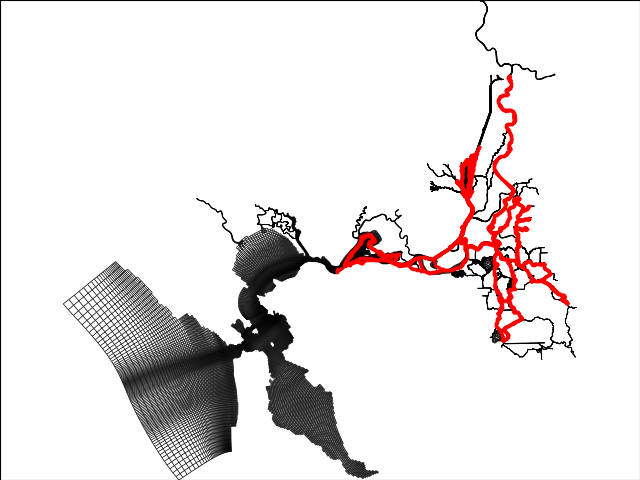

In [25]:
# Where was this cruise?
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
ax.set_position([0,0,1,1])

map_ds.grid.plot_edges(lw=0.5,color='k',ax=ax)
ax.plot(cruise_w_tau.x, cruise_w_tau.y, 'r.',ms=3, alpha=0.5)

<IPython.core.display.Javascript object>


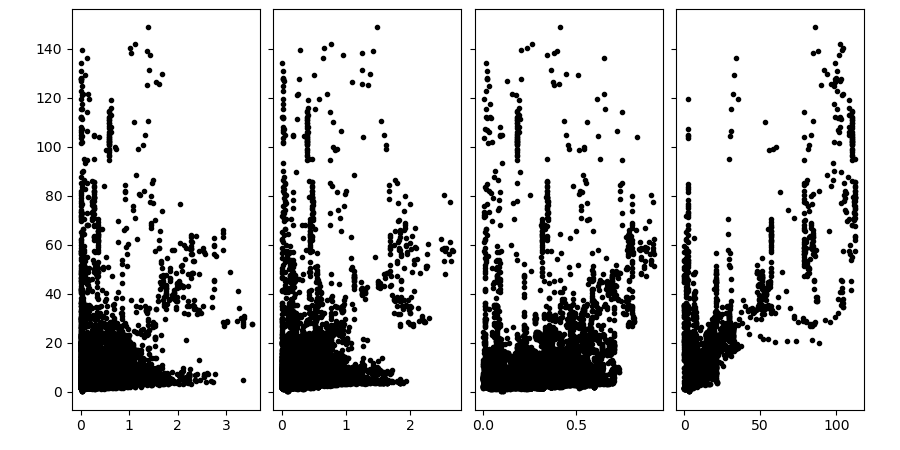

In [26]:
fig,axs=plt.subplots(1,4,sharex=False,sharey=True,figsize=(9,4.5))

for ax,scal in zip(axs,['tau','tau0','tau1','pred_diff']):
    ax.plot(cruise_w_tau[scal], cruise_w_tau['turb'], 'k.')

fig.subplots_adjust(left=0.08,right=0.96,top=0.98,bottom=0.09, wspace=0.07)


In [27]:
# Start trying some multiple linear regression
# Doing this for a single day of underway, 2018-07-25. Turns out
# the diffusion predictor on this day is pretty bad. Either it's a tricky
# day, or the skill of the diffusion predictor is coming largely from the
# cruise-to-cruise temporal variability, and not really from the interpolation. 

In [28]:
mod = smf.ols(formula='turb ~ tau', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     452.0
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.89e-98
Time:                        18:29:26   Log-Likelihood:                -47899.
No. Observations:               11793   AIC:                         9.580e+04
Df Residuals:                   11791   BIC:                         9.582e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3421      0.168     43.790      0.000       7.013       7.671
tau            6.0555      0.285     21.259      0.000       5.497       6.614
==============================================================================
Omnibus:                    11255.824   Durbin-Watson:                   0.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           442565.272
Skew:                           4.755   Prob(JB):                         0.00
Kurtosis:                      31.464   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
mod = smf.ols(formula='turb ~ tau0', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     686.6
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          3.79e-147
Time:                        18:29:26   Log-Likelihood:                -47787.
No. Observations:               11793   AIC:                         9.558e+04
Df Residuals:                   11791   BIC:                         9.559e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4054      0.177     36.163      0.000       6.058       6.753
tau0           8.6165      0.329     26.203      0.000       7.972       9.261
==============================================================================
Omnibus:                    11269.499   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           456231.820
Skew:                           4.751   Prob(JB):                         0.00
Kurtosis:                      31.952   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
mod = smf.ols(formula='turb ~ tau1', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     367.5
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.12e-80
Time:                        18:29:26   Log-Likelihood:                -47940.
No. Observations:               11793   AIC:                         9.588e+04
Df Residuals:                   11791   BIC:                         9.590e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0592      0.226     26.791      0.000       5.616       6.502
tau1          12.4014      0.647     19.169      0.000      11.133      13.670
==============================================================================
Omnibus:                    11373.565   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           464074.000
Skew:                           4.822   Prob(JB):                         0.00
Kurtosis:                      32.179   Cond. No.                         5.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
mod = smf.ols(formula='turb ~ pred_diff', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 2.401e+04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -41571.
No. Observations:               11793   AIC:                         8.315e+04
Df Residuals:                   11791   BIC:                         8.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4056      0.089     27.089      0.000       2.232       2.580
pred_diff      0.7693      0.005    154.966      0.000       0.760       0.779
==============================================================================
Omnibus:                    11420.525   Durbin-Watson:                   0.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           905162.589
Skew:                           4.554   Prob(JB):                         0.00
Kurtosis:                      44.942   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mod = smf.ols(formula='turb ~ pred_advd', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                 2.019e+04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -42238.
No. Observations:               11793   AIC:                         8.448e+04
Df Residuals:                   11791   BIC:                         8.449e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0388      0.105      0.371      0.711      -0.166       0.244
pred_advd      1.2091      0.009    142.082      0.000       1.192       1.226
==============================================================================
Omnibus:                    11129.027   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           597987.979
Skew:                           4.520   Prob(JB):                         0.00
Kurtosis:                      36.693   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Kitchen sink:
mod = smf.ols(formula='turb ~ tau + tau1 + tau0 + pred_diff + pred_advd', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     5168.
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:29:26   Log-Likelihood:                -41276.
No. Observations:               11793   AIC:                         8.256e+04
Df Residuals:                   11787   BIC:                         8.261e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4381      0.136     17.892      0.000       2.171       2.705
tau           -1.4503      0.279     -5.205      0.000      -1.996      -0.904
tau1          -5.5054      0.615     -8.952      0.000      -6.711      -4.300
tau0           2.0392      0.419      4.863      0.000       1.217       2.861
pred_diff      0.5242      0.013     41.640      0.000       0.499       0.549
pred_advd      0.4578      0.021     22.328      0.000       0.418       0.498
==============================================================================
Omnibus:                    11711.313   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           868842.643
Skew:                           4.788   Prob(JB):                         0.00
Kurtosis:                      43.945   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Half-kitchen sink:
# Was interesting on a single day, but not so interesting across multiple days
# 2018-07-25: R2=0.202
# turb = 16.88 tau0 - 11.23 tau1 - 4.59 tau + 6.25
# But does it hold for other days / regions?
# 2018-07-24: R2=0.248
# turb = -2.96 tau0 + 13.44 tau1 + 1.71 tau + 3.11 
# 2018-07-26: Rs=0.182
# turb = -8.46 tau0 -3.2 tau1 -9.62 tau + 32
# Basically useless. The various tau values provide some spatial patterns that 
# loosely tag water, and OLS overfits.
mod = smf.ols(formula='turb ~ tau0 + tau1 + tau', data=cruise_w_tau)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   turb   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     230.2
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          3.63e-145
Time:                        18:29:53   Log-Likelihood:                -47785.
No. Observations:               11793   AIC:                         9.558e+04
Df Residuals:                   11789   BIC:                         9.561e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6709      0.227     29.351      0.000       6.225       7.116
tau0           9.2590      0.723     12.805      0.000       7.842      10.676
tau1          -1.9900      1.039     -1.915      0.056      -4.027       0.047
tau            0.1743      0.480      0.363      0.716      -0.766       1.114
==============================================================================
Omnibus:                    11242.458   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451529.947
Skew:                           4.735   Prob(JB):                         0.00
Kurtosis:                      31.796   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Bed stress was weakly predictive turbidity when trained on the full 
set of underway data. Three different aggregations of bed stress were
tested: instantaneous, one hour exponential smoothing, and 24 h
exponential smoothing. Of those model outputs, one hour smoothing
was the most predictive but still had an R$^2$ of only 0.05. This
analysis quantized all times to integer hours, which also decreased
the skill of the diffusion and adv+diffusion approaches. These
attained R$^2$ scores of 0.671 and 0.631, respectively.



In [35]:
# Rather than comparing over underway data, compare with monitoring data since 
# that is what we'd be using in a real application.

# 15 minute data, 38 sites, 2018-04-01 to 2018-11-01
mon_ds=turb_ds 
mon_and_map_fn = "turb-mon_and_map.nc"

# Since we have decaying tracers spinup doesn't need to be all that long.
spinup_period = np.timedelta64(10,'D')

time_sel=( (mon_ds.time.values>= map_ds.time.values[0] + spinup_period)
          &(mon_ds.time.dt.minute.values==0))

mon_ds=mon_ds.isel(time=time_sel)

# Pull these from the model output 
map_fields=[
 'mesh2d_turb_wt',
 'mesh2d_turb_wtobs',
 'mesh2d_taus',
 'mesh2d_tauDecay0',
 'mesh2d_tauDecay1',
]

data={f:np.full((mon_ds.dims['time'], mon_ds.dims['site']),np.nan)
      for f in map_fields}

site_xy=np.c_[mon_ds.x.values, mon_ds.y.values]
site_cell=[map_ds.grid.select_cells_nearest(xy) for xy in site_xy]

for mon_tidx in utils.progress(range(mon_ds.dims['time'])):
    mon_time = mon_ds.time.values[mon_tidx]
    snap=map_ds.isel(time=np.searchsorted(map_ds.time.values, mon_time))
    
    for f in map_fields:
        data[f][mon_tidx,:] = snap[f].isel(mesh2d_nFaces=site_cell)
        

INFO:utils:12/4896
INFO:utils:25/4896
INFO:utils:38/4896
INFO:utils:51/4896
INFO:utils:63/4896
INFO:utils:76/4896
INFO:utils:88/4896
INFO:utils:101/4896
INFO:utils:114/4896
INFO:utils:127/4896
INFO:utils:140/4896
INFO:utils:153/4896
INFO:utils:166/4896
INFO:utils:180/4896
INFO:utils:193/4896
INFO:utils:206/4896
INFO:utils:219/4896
INFO:utils:232/4896
INFO:utils:245/4896
INFO:utils:257/4896
INFO:utils:271/4896
INFO:utils:284/4896
INFO:utils:297/4896
INFO:utils:311/4896
INFO:utils:325/4896
INFO:utils:338/4896
INFO:utils:352/4896
INFO:utils:365/4896
INFO:utils:379/4896
INFO:utils:393/4896
INFO:utils:406/4896
INFO:utils:420/4896
INFO:utils:434/4896
INFO:utils:448/4896
INFO:utils:462/4896
INFO:utils:475/4896
INFO:utils:489/4896
INFO:utils:503/4896
INFO:utils:517/4896
INFO:utils:530/4896
INFO:utils:544/4896
INFO:utils:557/4896
INFO:utils:570/4896
INFO:utils:583/4896
INFO:utils:596/4896
INFO:utils:609/4896
INFO:utils:622/4896
INFO:utils:635/4896
INFO:utils:648/4896
INFO:utils:662/4896
INFO:ut

INFO:utils:4829/4896
INFO:utils:4841/4896
INFO:utils:4853/4896
INFO:utils:4866/4896
INFO:utils:4878/4896
INFO:utils:4890/4896


In [36]:
for f in map_fields:
    mon_ds[f]=('time','site'), data[f]

In [37]:
mon_ds.to_netcdf(mon_and_map_fn)